In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

Connect Google Drive.  This is done so that the models and data reading can be standard across the different testing environments and any changes will be universal.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Weather')

from seq_to_seq import MultiHeadModel, LSTM_Model
from process import df_to_np_seq

Mounted at /content/drive


df_to_np is a helper functions to convert csv to training data format

x = last (context_window) readings

y = next reading

If there is a blank or invalid value, that entry is skipped.  This can lead to (context_window) readings that are not (context_window) consecutive hours but are (context_window) entries

In [ ]:
def replace_blanks(df):
  '''Replaces all invalids with the most recent valid in that column'''
  df = df.replace('', np.nan)
  df = df.fillna(method='ffill')
  df = df.dropna()

  return df

Read in the data

In [ ]:
context_window = 48

In [ ]:
df_train = pd.read_csv('/content/processed_data/train.csv')
df_train = df_train.set_index(['USAF ID',
                               'Observation Year',
                               'Observation Month',
                               'Observation Day',
                               'Observation Hour'])

df_test = pd.read_csv('/content/processed_data/test.csv')
df_test = df_test.set_index(['USAF ID',
                             'Observation Year',
                             'Observation Month',
                             'Observation Day',
                             'Observation Hour'])

start_year, end_year = 2010, 2024
USAFs_train = ['720553', '744860', '725030', '725020', '725053']
USAFs_test = ['744864']

df_train = replace_blanks(df_train)
df_test = replace_blanks(df_test)

x_train, y_train, _ = df_to_np_seq(df_train, USAFs_train, start_year, end_year, context_window)
x_test, y_test, test_hi_lows = df_to_np_seq(df_test, USAFs_test, start_year, end_year, context_window)

print(f'{len(x_train)} training samples')
print(f'{len(x_test)} testing samples')


1/5
2/5
3/5
4/5
5/5
1/1
11657 training samples
2592 testing samples


Normalize the data before training

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

timesteps = len(x_train[0])
features = len(x_train[0][0])

x_train_reshaped = x_train.reshape(len(x_train) * timesteps, -1)
x_test_reshaped = x_test.reshape(len(x_test) * timesteps, -1)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_test_scaled = scaler.transform(x_test_reshaped)

x_train = x_train_scaled.reshape(len(x_train), timesteps, features)
x_test = x_test_scaled.reshape(len(x_test), timesteps, features)

# targets
y_train_reshape = y_train.reshape(len(x_train) * timesteps, -1)
y_test_reshape = y_test.reshape(len(x_test) * timesteps, -1)

y_train_scaled = scaler.transform(y_train_reshape)
y_test_scaled = scaler.transform(y_test_reshape)

y_train = y_train_scaled.reshape(len(x_train), timesteps, features)
y_test = y_test_scaled.reshape(len(x_test), timesteps, features)


Shuffle order

In [ ]:
indices = np.random.permutation(len(x_train))

x_train = x_train[indices]
y_train = y_train[indices]

Build Validation Set

In [ ]:
valid_split = int(len(x_train) * 0.05)

x_valid = x_train[:valid_split]
y_valid = y_train[:valid_split]

x_train = x_train[valid_split:]
y_train = y_train[valid_split:]

Build the model

In [ ]:
from tensorflow.keras.layers import Input, MultiHeadAttention, Add, LayerNormalization, Dense

seq_len = context_window  # Length of time series
d_model = 7  # Single entry dimension
num_heads = 8  # Number of attention heads
# out_seq_len = out_window # Number of series to predict
batch_size = 2

Multihead Attention Approach

In [ ]:
model = MultiHeadModel(seq_len, d_model, num_heads)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 7)]              0         []                            
                                                                                                  
 mha1 (MultiHeadAttention)   (None, 48, 7)                1743      ['input[0][0]',               
                                                                     'input[0][0]',               
                                                                     'input[0][0]']               
                                                                                                  
 add1 (Add)                  (None, 48, 7)                0         ['input[0][0]',               
                                                                     'mha1[0][0]']            

LSTM Approach

In [ ]:
model = LSTM_Model(seq_len, d_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 7)]              0         []                            
                                                                                                  
 lstm1 (LSTM)                (None, 48, 14)               1232      ['input[0][0]']               
                                                                                                  
 dense (Dense)               (None, 48, 7)                105       ['lstm1[0][0]']               
                                                                                                  
 add1 (Add)                  (None, 48, 7)                0         ['input[0][0]',               
                                                                     'dense[0][0]']         

Create sequence to sequence loss


In [ ]:
def custom_seq_prediction_loss(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.math.reduce_mean(mse)

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
model.compile(loss=custom_seq_prediction_loss, optimizer=opt)

In [ ]:
# Train the model and store model parameters/loss values
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=[x_valid, y_valid], callbacks=[reduce_lr])#, shuffle=True)

Epoch 1/20
5538/5538 [==============================] - 87s 15ms/step - loss: 0.2818 - val_loss: 0.1858 - lr: 0.0010
Epoch 2/20
5538/5538 [==============================] - 78s 14ms/step - loss: 0.1813 - val_loss: 0.1843 - lr: 0.0010
Epoch 3/20
5538/5538 [==============================] - 75s 14ms/step - loss: 0.1787 - val_loss: 0.1803 - lr: 0.0010
Epoch 4/20
5538/5538 [==============================] - 75s 13ms/step - loss: 0.1768 - val_loss: 0.1774 - lr: 0.0010
Epoch 5/20
5538/5538 [==============================] - 76s 14ms/step - loss: 0.1753 - val_loss: 0.1762 - lr: 0.0010
Epoch 6/20
5538/5538 [==============================] - 75s 14ms/step - loss: 0.1734 - val_loss: 0.1748 - lr: 0.0010
Epoch 7/20
5538/5538 [==============================] - 75s 13ms/step - loss: 0.1719 - val_loss: 0.1730 - lr: 0.0010
Epoch 8/20
5538/5538 [==============================] - 76s 14ms/step - loss: 0.1706 - val_loss: 0.1714 - lr: 0.0010
Epoch 9/20
5538/5538 [==============================] - 75s 13ms

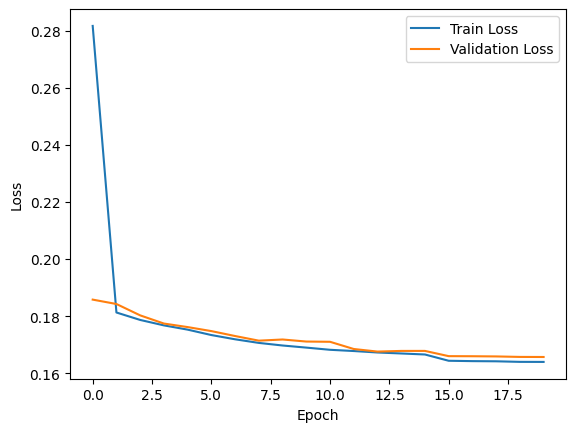

In [ ]:
# Plot the loss curve
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [ ]:
x_test = np.array(x_test)
y_test = np.array(y_test)
model.evaluate(x_test, y_test, batch_size=batch_size)

1296/1296 [==============================] - 6s 4ms/step - loss: 0.1668


0.16684435307979584

Evalutate on the baseline target which is the next 24hr High and Low temps

In [ ]:
def n_next_steps(input, model, n, context_window):
    '''Takes an autoregressive model and returns the n next predictions'''
    out = np.zeros((input.shape[0], n, d_model))
    for i in range(n):
        print(f'{i+1}/{n}\r', end='', flush=True)
        next = model.predict(input, verbose=0)
        out[:, i] = scaler.inverse_transform(next[:, -1, :])
        input = np.roll(input, -1, axis=1)
        input[:, -1] = next[:, -1, :]

    return out


In [ ]:
pred_hi_lows = np.zeros((len(x_test), 2))
pred = n_next_steps(x_test, model, 24, context_window)
hi = np.max(pred[:, :, 0], axis=1)
low = np.min(pred[:, :, 0], axis=1)

pred_hi_lows[:, 0] = hi
pred_hi_lows[:, 1] = low

loss = tf.keras.losses.mean_squared_error(test_hi_lows, pred_hi_lows)
loss = np.mean(loss)
print(loss)

30.85417642246309


Show n actual samples

In [ ]:
num_samples = 10
for i in range(num_samples):
  print(f'Prediction:   {pred_hi_lows[i]} \nGround Truth: {test_hi_lows[i]} \n')

Prediction:   [-3.09319997 -5.67255688] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [ 4.18129349 -4.07026196] 
Ground Truth: [ 1.7 -3.3] 

Prediction:   [-2.22374272 -7.38369656] 
Ground Truth: [ 0.6 -2.8] 

Prediction:   [ -2.98008084 -15.99476528] 
Ground Truth: [ -1.7 -10. ] 

Prediction:   [ 1.58964527 -4.7831831 ] 
Ground Truth: [ 1.7 -3.3] 

Prediction:   [-4.11043644 -6.83501148] 
Ground Truth: [ 3.9 -6.1] 

Prediction:   [-1.20779908 -8.95153332] 
Ground Truth: [ 9.4 -1.7] 

Prediction:   [ 1.21902549 -3.4474957 ] 
Ground Truth: [9.4 2.8] 

Prediction:   [3.40480971 1.49689376] 
Ground Truth: [ 6.1 -0.6] 

Prediction:   [ 2.92824531 -0.92338866] 
Ground Truth: [ 5.  -1.1] 



In [ ]:
num_samples = 10
X = model.predict(np.array(x_test[:num_samples]))
for i in range(num_samples):
  x_out = scaler.inverse_transform([X[i][-1]])
  y_out = scaler.inverse_transform([y_test[i][-1]])
  print(f'Prediction:   {x_out} \nGround Truth: {y_out} \n')



1/1 [==============================] - 1s 1s/step
Prediction:   [[-6.10963597e+00 -1.48913485e+01  1.00417414e+03  3.13779756e+02
   8.65884921e+00  7.51484195e+00  3.19875061e-01]] 
Ground Truth: [[  -7.2  -15.  1003.6  320.     7.7    4.     0. ]] 

Prediction:   [[-2.92850257e+00 -1.35093590e+01  1.00679617e+03  2.93062479e+02
   4.21170951e+00  1.18878968e+00 -3.60947538e-01]] 
Ground Truth: [[  -4.4  -11.1 1006.7  320.     3.6    0.     0. ]] 

Prediction:   [[-3.48449706e-01 -1.12952794e+01  1.00752646e+03  2.95699080e+02
   4.51660738e+00  1.14803719e+00 -1.11507426e-01]] 
Ground Truth: [[  -2.2   -8.3 1007.7  310.     5.7    0.     0. ]] 

Prediction:   [[-2.81768862e+00 -1.49006487e+01  1.01128302e+03  3.05989541e+02
   5.61041472e+00  1.04360901e+00 -1.81012783e-01]] 
Ground Truth: [[  -5.6  -12.2 1011.5  320.     6.7    0.     0. ]] 

Prediction:   [[-4.39207437e+00 -1.48315704e+01  1.02273375e+03  2.35450207e+02
   1.92769459e+00  9.00566905e-01 -2.93461079e-01]] 
Ground Tr